In [1]:
#import all libraries
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf       #最新版本1.0

In [2]:
#import dataset

from google.colab import drive
import pandas as pd
drive.mount("/content/drive")

dataset =pd.read_csv("/content/drive/My Drive/專案code/Hotel/City.csv")

Mounted at /content/drive


In [3]:
dataset.head()

,平均值 - lead_time,平均值 - stays_in_weekend_nights,平均值 - stays_in_week_nights,加總 - previous_cancellations,加總 - previous_bookings_not_canceled,平均值 - adr,加總 - is_canceled
0,219.406593,0.500000,2.126374,80,0,78.165879,97
1,174.135514,1.037383,2.238318,117,0,70.247336,153
2,190.928977,0.872159,1.869318,162,0,73.996534,228
3,166.867550,0.768212,1.726269,244,0,66.766446,321
4,155.461207,0.943966,1.642241,104,0,65.363578,159


In [4]:
x_no= 7        # x的變數個數
step_ahead=1  # 往前預測幾筆 (往前預測一期)
seq_len = 4    # taken sequence length as 10
               # time window = 8

In [5]:
df_stock = dataset.copy()      #複製資料集到df_stock
df_stock = df_stock.dropna()   #dropna 去掉missing data

In [6]:
#normalize the dataset (把每一個變數壓縮的0~1之間[標準化])

from sklearn import preprocessing as skpp   #呼叫兩個副程式
from pandas import DataFrame

scaler = skpp.MinMaxScaler(feature_range=(0, 1))      #(0,1)=(min,max)
df_stock1 =df_stock.iloc[:,np.arange(0,x_no)]         # iloc=值  #列：行 在此列資料全吃(0,x_no) 控制多少資料
df_stock_norm = DataFrame(scaler.fit_transform(df_stock1))       # scaler對df_stock1標準化 轉成dataframe


In [7]:
#Splitting the dataset into Train, Valid & test data

valid_set_size_percentage = 0
test_set_size_percentage = 30

#定義副程式 stock引述
#執行此副程式時 名字為stock
def load_data(stock, seq_len):
    data_raw = stock.values
    data = []
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:-step_ahead,:]
    y_train = data[:train_set_size,-1, 6:7]
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-step_ahead,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1, 6:7]
    x_test = data[train_set_size+valid_set_size:,: -step_ahead,:]
    y_test = data[train_set_size+valid_set_size:,-1, 6:7]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (78, 3, 7)
y_train.shape =  (78, 1)
x_valid.shape =  (0, 3, 7)
y_valid.shape =  (0, 1)
x_test.shape =  (33, 3, 7)
y_test.shape =  (33, 1)


In [8]:
#Building the Model

# Parameters & Placeholders  [須改的參數]
n_steps = seq_len-step_ahead
n_inputs = x_no             # x input
n_neurons = 100             #隱藏層神經元
n_outputs = 1               #y output=1
n_layers = 2              #3層RNN
learning_rate = 0.0005
batch_size = 5
n_epochs = 250              #訓練次數
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
tf.disable_eager_execution()

#[制式]
#用 tf.placeholder 創造出未來存放 x 與 y 值的地方
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# function to get the next batch
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])  # 創造出資料筆數一樣的數列
np.random.shuffle(perm_array)            # 隨機排列

#[可不理]
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size         # 累加batch_size
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array)   # shuffle permutation array
        start = 0                       # start next epoch
        index_in_epoch = batch_size
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]


##tf.disable_v2_behavior()
##tf.compat.v1.disable_eager_execution()


In [9]:
#RNN

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]
##layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
##         for layer in range(n_layers)]   #宣告網路架構 有幾層 一層內有幾個cell
## print (layers.state_size)

## multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)

## print (multi_layer_cell.state_size)

rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
	                                           #调用dynamic_rnn进行时序的运算
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:]             #keep only last output of sequence


#Cost function
loss = tf.reduce_mean(tf.square(outputs - y))

#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op =optimizer.minimize(loss)

# Fitting the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch
        sess.run(training_op,feed_dict={X: x_batch, y: y_batch})
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

# Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    y_train_pred = sess.run(outputs, feed_dict={X: x_train})

#Checking prediction output nos
y_test_pred.shape
y_train_pred.shape


<ipython-input-9-0292d9960230>:3: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
<ipython-input-9-0292d9960230>:17: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)


0.00 epochs: MSE train/valid = 0.047245/nan
5.00 epochs: MSE train/valid = 0.021528/nan
10.00 epochs: MSE train/valid = 0.020569/nan
15.00 epochs: MSE train/valid = 0.020495/nan
20.00 epochs: MSE train/valid = 0.019549/nan
25.00 epochs: MSE train/valid = 0.019366/nan
30.00 epochs: MSE train/valid = 0.020783/nan
35.00 epochs: MSE train/valid = 0.018697/nan
40.00 epochs: MSE train/valid = 0.020491/nan
45.00 epochs: MSE train/valid = 0.017892/nan
50.00 epochs: MSE train/valid = 0.017429/nan
55.00 epochs: MSE train/valid = 0.017512/nan
60.00 epochs: MSE train/valid = 0.016213/nan
65.00 epochs: MSE train/valid = 0.018981/nan
70.00 epochs: MSE train/valid = 0.016137/nan
75.00 epochs: MSE train/valid = 0.014845/nan
80.00 epochs: MSE train/valid = 0.014518/nan
85.00 epochs: MSE train/valid = 0.013785/nan
90.00 epochs: MSE train/valid = 0.012911/nan
95.00 epochs: MSE train/valid = 0.012681/nan
100.00 epochs: MSE train/valid = 0.017293/nan
105.00 epochs: MSE train/valid = 0.012471/nan
110.00 epo

(78, 1)

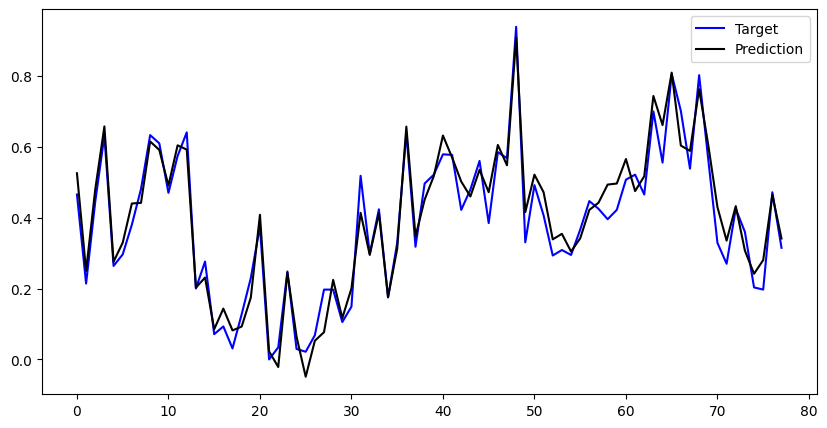

In [10]:
#checking prediction output nos
y_test_pred.shape
y_train_pred.shape


#ploting the graph
comp = pd.DataFrame({'Column1':y_train[:,0],'Column2':y_train_pred[:,0]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()

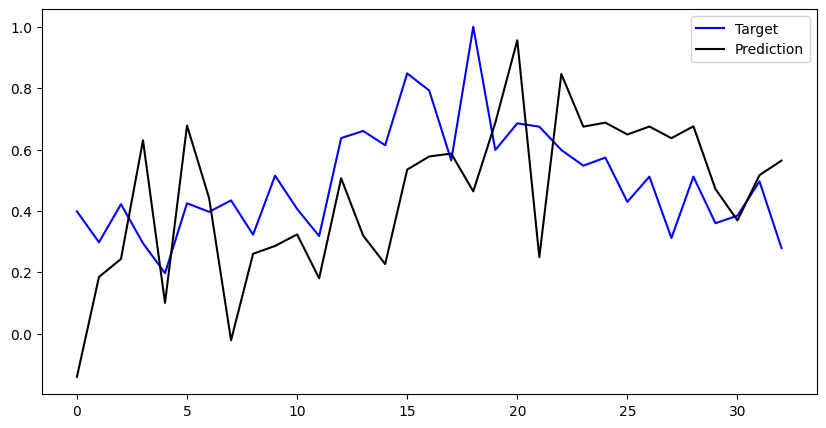

In [11]:
#ploting the graph
comp = pd.DataFrame({'Column1':y_test[:,0],'Column2':y_test_pred[:,0]})  ##  現在只有單一一個 y 變數 所以 3改成 0
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()

In [12]:
# LSTM
layers = [tf.nn.rnn_cell.LSTMCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

## layers = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
##         for layer in range(n_layers)]   ## 也可以!
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#        for layer in range(n_layers)]

#LSTM with peephole connections
#layers = [tf.nn.rnn_cell.LSTMCell(num_units=n_neurons, activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]
## layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, activation=tf.nn.leaky_relu, use_peepholes = True)
##          for layer in range(n_layers)]


## multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)

## print (multi_layer_cell.state_size)

rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:]

# Cost function
loss = tf.reduce_mean(tf.square(outputs - y))

#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Fitting the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
# Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    y_train_pred = sess.run(outputs, feed_dict={X: x_train})


<ipython-input-12-7edd857dc25c>:2: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  layers = [tf.nn.rnn_cell.LSTMCell(num_units=n_neurons, activation=tf.nn.elu)
<ipython-input-12-7edd857dc25c>:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)


0.00 epochs: MSE train/valid = 0.176893/nan
5.00 epochs: MSE train/valid = 0.024118/nan
10.00 epochs: MSE train/valid = 0.022590/nan
15.00 epochs: MSE train/valid = 0.022322/nan
20.00 epochs: MSE train/valid = 0.022602/nan
25.00 epochs: MSE train/valid = 0.022805/nan
30.00 epochs: MSE train/valid = 0.021941/nan
35.00 epochs: MSE train/valid = 0.022098/nan
40.00 epochs: MSE train/valid = 0.023367/nan
45.00 epochs: MSE train/valid = 0.022178/nan
50.00 epochs: MSE train/valid = 0.021642/nan
55.00 epochs: MSE train/valid = 0.021636/nan
60.00 epochs: MSE train/valid = 0.021666/nan
65.00 epochs: MSE train/valid = 0.021372/nan
70.00 epochs: MSE train/valid = 0.021496/nan
75.00 epochs: MSE train/valid = 0.021198/nan
80.00 epochs: MSE train/valid = 0.022154/nan
85.00 epochs: MSE train/valid = 0.022809/nan
90.00 epochs: MSE train/valid = 0.020893/nan
95.00 epochs: MSE train/valid = 0.020775/nan
100.00 epochs: MSE train/valid = 0.020699/nan
105.00 epochs: MSE train/valid = 0.020576/nan
110.00 epo

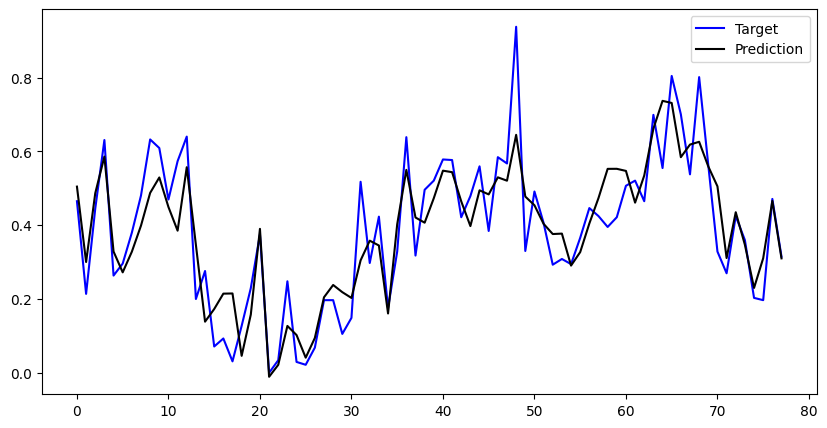

In [13]:
#checking prediction output nos
y_test_pred.shape
y_train_pred.shape


#ploting the graph
comp = pd.DataFrame({'Column1':y_train[:,0],'Column2':y_train_pred[:,0]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()


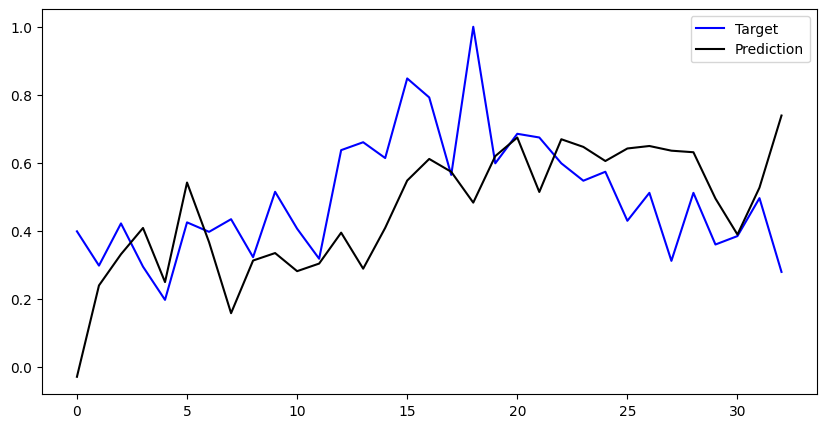

In [14]:
#ploting the graph
comp = pd.DataFrame({'Column1':y_test[:,0],'Column2':y_test_pred[:,0]})  ##  現在只有單一一個 y 變數 所以 3改成 0
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()

In [15]:
#GRU
layers = [tf.nn.rnn_cell.GRUCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]

#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
## multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)

## print (multi_layer_cell.state_size)

rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
	# 調用dynamic_rnn進行時序的運算
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

# Cost function
loss = tf.reduce_mean(tf.square(outputs - y))

#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Fitting the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})  # Predictions
    y_train_pred = sess.run(outputs, feed_dict={X: x_train})

#checking prediction output nos
y_test_pred.shape
y_train_pred.shape


<ipython-input-15-189c9953b649>:2: UserWarning: `tf.nn.rnn_cell.GRUCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.GRUCell`, and will be replaced by that in Tensorflow 2.0.
  layers = [tf.nn.rnn_cell.GRUCell(num_units=n_neurons, activation=tf.nn.elu)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
<ipython-input-15-189c9953b649>:15: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)


0.00 epochs: MSE train/valid = 0.169072/nan
5.00 epochs: MSE train/valid = 0.024511/nan
10.00 epochs: MSE train/valid = 0.023348/nan
15.00 epochs: MSE train/valid = 0.022185/nan
20.00 epochs: MSE train/valid = 0.022470/nan
25.00 epochs: MSE train/valid = 0.021863/nan
30.00 epochs: MSE train/valid = 0.026311/nan
35.00 epochs: MSE train/valid = 0.021589/nan
40.00 epochs: MSE train/valid = 0.021477/nan
45.00 epochs: MSE train/valid = 0.021323/nan
50.00 epochs: MSE train/valid = 0.021146/nan
55.00 epochs: MSE train/valid = 0.021507/nan
60.00 epochs: MSE train/valid = 0.021143/nan
65.00 epochs: MSE train/valid = 0.020939/nan
70.00 epochs: MSE train/valid = 0.021195/nan
75.00 epochs: MSE train/valid = 0.020500/nan
80.00 epochs: MSE train/valid = 0.021876/nan
85.00 epochs: MSE train/valid = 0.020233/nan
90.00 epochs: MSE train/valid = 0.020317/nan
95.00 epochs: MSE train/valid = 0.019769/nan
100.00 epochs: MSE train/valid = 0.019625/nan
105.00 epochs: MSE train/valid = 0.019735/nan
110.00 epo

(78, 1)

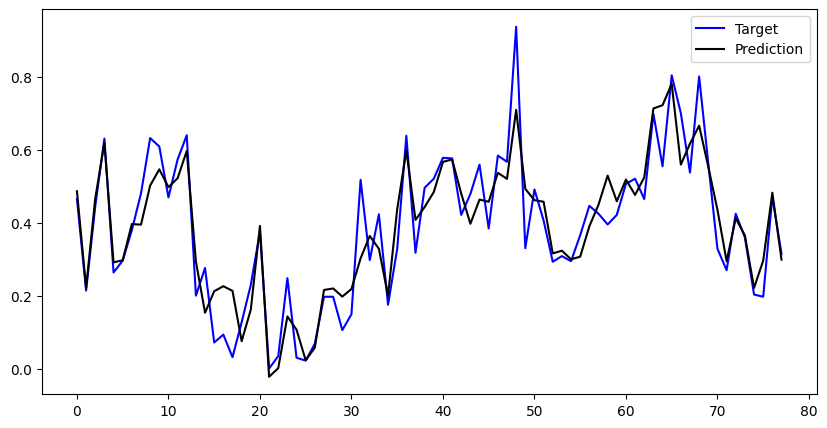

In [16]:
#checking prediction output nos
y_test_pred.shape
y_train_pred.shape


#ploting the graph
comp = pd.DataFrame({'Column1':y_train[:,0],'Column2':y_train_pred[:,0]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()


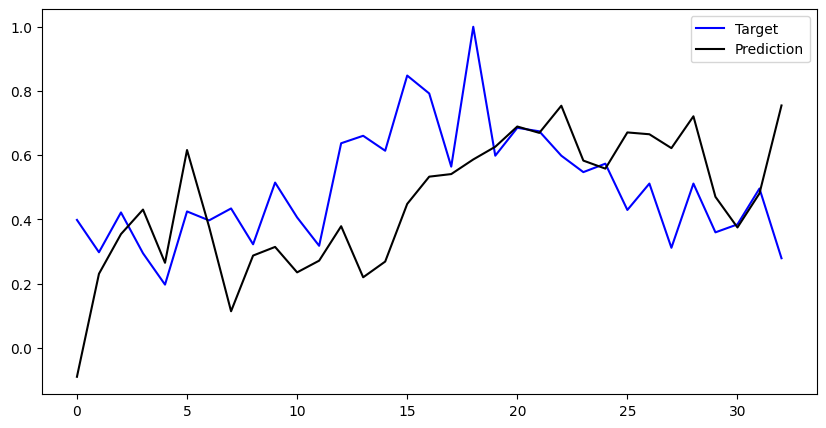

In [17]:
#ploting the graph
comp = pd.DataFrame({'Column1':y_test[:,0],'Column2':y_test_pred[:,0]})  ##  現在只有單一一個 y 變數 所以 3改成 0
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()
